### Team Classy Pie
---
# ■ Shelter Animal Outcomes, 보호소 동물들의 운명 예측하기

## Contents
> ### 1. Introduction -  프로젝트 소개
> ### 2. Datasets - 데이터 소개
> ### 3. Evaluation - 평가기준
> ### 4. EDA - 탐색적 자료 분석
> ### 5. Feature Engineering - 데이터 전처리
> ### 6. Modeling - 예측모델 
> ### 7. Cross Validation - 모델평가 및 검증
> ### 8. Make Kaggle Score - 캐글 제출 및 결과확인
> ### 9. Conclusion - 결론


---

# 1. Introduction

    
> ### 1-1. 미국의 애완동물 현황
> - 미국 가정의 약 44%가 애완 동물을 기른다.
> - 매년 미국에서 760만 마리가 아래의 이유로 보호소에 오게 된다.    
    - 주인이 원치 않음
    - 길을 잃음
    - 학대를 당함
>
>
> - 보호소에 오는 동물들이 주인을 찾아가기도 하지만 **매년 270만 마리, 약 35%는 안락사**를 당한다.
    

> ### 1-2. 프로젝트 목표
> - 미국 텍사스의 **Austin Animal Center**는 모든 동물들에게 집을 찾아주는 것을 목표
> - 동물들의 특성 데이터를 제공해서 각 동물들의 결과를 예측
> - 입양이 덜 되는 동물들에게 에너지를 쏟아 입양률을 높이기 위한 목적

---
# 2. Datasets

- 총 3개의 파일
    
> ### 2-1. Train & Test
> - 2013.10 ~ 2016.03 기간동안 보호소에 온 강아지, 고양이의 정보
>
> - train.csv : the training set
> - test.csv : the test set
    

In [201]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [177]:
print("◆ Note : 트레인 파일은 아래와 같다.")
train.tail(3)

◆ Note : 트레인 파일은 아래와 같다.


,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
26726,A698128,Zeus,2015-03-09 13:33:00,Adoption,NaN,Dog,Neutered Male,4 years,Old English Bulldog Mix,White/Tan
26727,A677478,NaN,2014-04-27 12:22:00,Transfer,Partner,Cat,Intact Male,4 weeks,Domestic Shorthair Mix,Black
26728,A706629,NaN,2015-07-02 09:00:00,Transfer,SCRP,Cat,Intact Male,1 year,Domestic Shorthair Mix,Brown Tabby/White


In [178]:
print("◆ Note : 테스트 파일은 아래와 같다. 트래인 데이터와는 달리 Outcome관련 컬럼이 없다는걸 알 수 있다.")
test.tail(3)

◆ Note : 테스트 파일은 아래와 같다. 트래인 데이터와는 달리 Outcome관련 컬럼이 없다는걸 알 수 있다.


,ID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
11453,11454,NaN,2014-09-29 09:00:00,Cat,Intact Female,1 year,Domestic Shorthair Mix,Calico
11454,11455,Rambo,2015-09-05 17:16:00,Dog,Neutered Male,6 years,German Shepherd Mix,Black/Tan
11455,11456,Gusto,2014-07-12 18:40:00,Dog,Intact Male,4 years,Labrador Retriever,Cream


In [179]:
print(train.shape)

(26729, 10)


- Train data의 컬럼
    - OutcomeType (예측해야할 target 값)
    - OutcomeSubtype (OutcomeType과 연계된 부가정보)
    - +Test data의 컬럼들
- Test data의 컬럼
    - AnimalID(중복되지않는 고유 ID)
    - Name(이름이 없는 경우가 많음)
    - DateTime(Outcome이 발생한 날짜기록)
    - AnimalType(강아지, 고양이)
    - SexuponOutcome(성별 및 중성화여부, 5가지)
    - AgeuponOutcome(동물의 나이)
    - Breed(종)
    - Color(색상)

> ### 2-2. Submission
> - sample_submission.csv : a sample submission file in the correct format
    - 모든 동물들이 떠날때 클래스별 예측 확률

--- 
# 3. Evalutaion

    Submissions are evaluated using the multi-class logarithmic loss.
    
    where N is the number of animals in the test set, M is the number of outcomes
    log is the natural logarithm
    yij is 1 if observation i is in outcome j and 0 otherwise
    pij is the predicted probability that observation i belongs to outcome j.
    


$ \Large -\frac{1}{N} \sum \sum y_{ij}log(p_{ij}) $

---
# 4. EDA & Feature Engineering

In [180]:
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import sklearn as sk

%matplotlib inline
%config InlineBackend.figure_formats = {'png','retina'}

import matplotlib as mpl
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()

pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)

## 4-1. raw data Analysis & Explore

In [181]:
print('-- 데이터 간략정보 --')
train.describe().T

-- 데이터 간략정보 --


,count,unique,top,freq
AnimalID,26729,26729,A672155,1
Name,19038,6374,Max,136
DateTime,26729,22918,2015-08-11 00:00:00,19
OutcomeType,26729,5,Adoption,10769
OutcomeSubtype,13117,16,Partner,7816
AnimalType,26729,2,Dog,15595
SexuponOutcome,26728,5,Neutered Male,9779
AgeuponOutcome,26711,44,1 year,3969
Breed,26729,1380,Domestic Shorthair Mix,8810
Color,26729,366,Black/White,2824


In [182]:
print("-- 컬럼별 null의 갯수 --")
pd.DataFrame(train.isnull().sum())

-- 컬럼별 null의 갯수 --


,0
AnimalID,0
Name,7691
DateTime,0
OutcomeType,0
OutcomeSubtype,13612
AnimalType,0
SexuponOutcome,1
AgeuponOutcome,18
Breed,0
Color,0


In [183]:
print('-- 중복자료 및 unique --')
train.describe().T

-- 중복자료 및 unique --


,count,unique,top,freq
AnimalID,26729,26729,A672155,1
Name,19038,6374,Max,136
DateTime,26729,22918,2015-08-11 00:00:00,19
OutcomeType,26729,5,Adoption,10769
OutcomeSubtype,13117,16,Partner,7816
AnimalType,26729,2,Dog,15595
SexuponOutcome,26728,5,Neutered Male,9779
AgeuponOutcome,26711,44,1 year,3969
Breed,26729,1380,Domestic Shorthair Mix,8810
Color,26729,366,Black/White,2824


-- OutcomeType의 내용 --


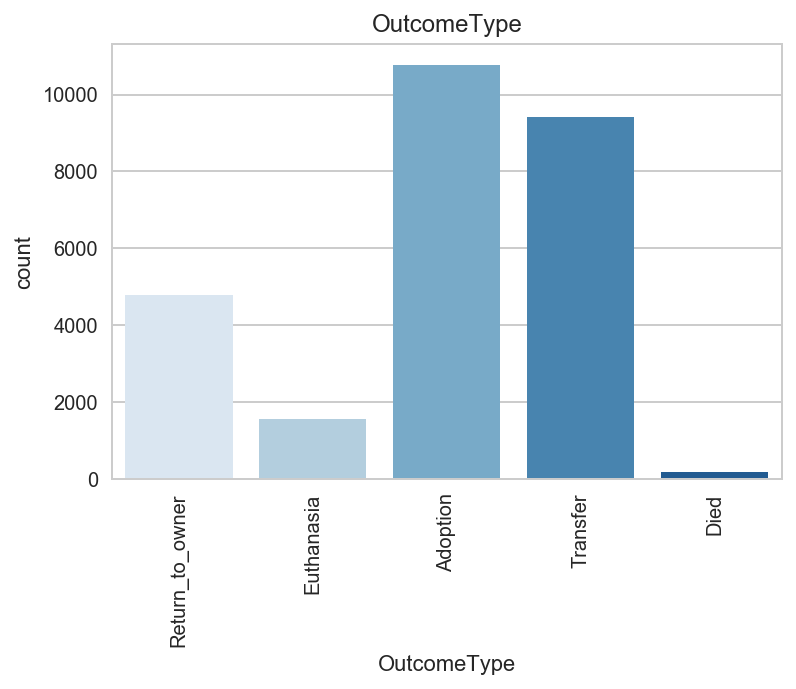

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: OutcomeType, dtype: int64

In [184]:
print("-- OutcomeType의 내용 --")
sns.countplot(x=train["OutcomeType"], data=train , palette="Blues")
plt.title('OutcomeType')
plt.xticks(rotation='vertical')
plt.show()
train["OutcomeType"].value_counts()

In [185]:
print("-- OutcomeSubtype의 내용 --")
train.groupby("OutcomeSubtype").size().reset_index(name='count').sort_values('count', ascending=False)

-- OutcomeSubtype의 내용 --


,OutcomeSubtype,count
12,Partner,7816
6,Foster,1800
14,SCRP,1599
15,Suffering,1002
0,Aggressive,320
11,Offsite,165
8,In Kennel,114
3,Behavior,86
13,Rabies Risk,74
10,Medical,66


In [186]:
print("-- AnimalType의 내용 --")
train.groupby("AnimalType").size().reset_index(name='count').sort_values('count',ascending=False)

-- AnimalType의 내용 --


,AnimalType,count
1,Dog,15595
0,Cat,11134


In [187]:
print("-- SexuponOutcome의 내용 --")
train.groupby("SexuponOutcome").size().reset_index(name='count').sort_values('count', ascending=False)

-- SexuponOutcome의 내용 --


,SexuponOutcome,count
2,Neutered Male,9779
3,Spayed Female,8820
1,Intact Male,3525
0,Intact Female,3511
4,Unknown,1093


In [188]:
print("-- AgeuponOutcome의 내용 --")
print("     - ※10개만 표시하고 중략")
train.groupby("AgeuponOutcome").size().reset_index(name='count').sort_values('count', ascending=False).head(10)

-- AgeuponOutcome의 내용 --
     - ※10개만 표시하고 중략


,AgeuponOutcome,count
5,1 year,3969
21,2 years,3742
19,2 months,3397
26,3 years,1823
2,1 month,1281
24,3 months,1277
30,4 years,1071
34,5 years,992
28,4 months,888
37,6 years,670


In [189]:
print("-- Breed의 내용 --")
print("     - 15개 항목만 표시하고 중략")
train.groupby("Breed").size().reset_index(name='count').sort_values('count', ascending=False).head(15)

-- Breed의 내용 --
     - 15개 항목만 표시하고 중략


,Breed,count
640,Domestic Shorthair Mix,8810
1066,Pit Bull Mix,1906
450,Chihuahua Shorthair Mix,1766
847,Labrador Retriever Mix,1363
637,Domestic Medium Hair Mix,839
696,German Shepherd Mix,575
632,Domestic Longhair Mix,520
1251,Siamese Mix,389
74,Australian Cattle Dog Mix,367
559,Dachshund Mix,318


In [190]:
print("-- Color의 내용 --")
print("    - 15개 항목만 표시하고 중략")
train.groupby("Color").size().reset_index(name='count').sort_values('count', ascending=False).head(15)

-- Color의 내용 --
    - 15개 항목만 표시하고 중략


,Color,count
38,Black/White,2824
5,Black,2292
104,Brown Tabby,1635
111,Brown Tabby/White,940
318,White,931
130,Brown/White,884
216,Orange Tabby,841
289,Tan/White,773
307,Tricolor,752
86,Blue/White,702


## 4-2. Feature Engineering & Analysis

### - 비정형 데이터 --> 정형화

In [202]:
def preprocessShelter(df):
    # Name --> Isname------------------------------------------
    df['Name'].fillna('Unknown', inplace=True)

    # 이름이 있으면 Has_name, 이름이 없으면 Unknown------------
    name = []
    for i in df['Name']:
        if i == 'Unknown':
            name.append('Unknown_name')
        else:
            name.append('Has_name')
    df['Name'] = name
    
    # 성별데이터 NaN값인 경우 예외처리 (mode값으로 편입)------
    df['SexuponOutcome'].fillna('Neutered Male', inplace=True)
    df.SexuponOutcome[df["SexuponOutcome"]=="Unknown"]="Unknown_Sex"
    
    # 나이데이터 정리1
    # Year, Month, Week, Day 로 나누어져 있음 --> 1년 이하생과 이상생으로 나눔
    age = []
    for i in df['AgeuponOutcome']:
        if 'year' in str(i):
            age.append('gte_1_year')
        else:
            age.append('lt_1_year')
            
    df['AgeuponOutcome'] = age
    
    # color정리 - black, white, brown, others로 나눔
    color = []
    for i in df['Color']:
        if i[:5] == 'Black':
            color.append('Black')
        elif i[:5] == 'White':
            color.append('White')
        elif i[:5] == 'Brown':
            color.append('Brown')
        else:
            color.append('C_Others')
    df['Color'] = color
    
    
    # One Hot Encoding ------------------------------------------
    Name = pd.get_dummies(df['Name'])
    Sex = pd.get_dummies(df['SexuponOutcome'])
    Age = pd.get_dummies(df['AgeuponOutcome'])
    Color = pd.get_dummies(df['Color'])
    
    one_hot_X = pd.concat([Name,Sex,Age,Color], axis=1)
    

    
    
    return df, one_hot_X

# 전처리된 데이터프레임 설정 --> df_train
df_train, df_X = preprocessShelter(train)

### - Name & OutcomeType

- `Name` column preprocessing
    - 동물의 이름
    - 동물이 이름을 가지고 있으면 Has_name, 이름을 가지지 않으면 Unknown


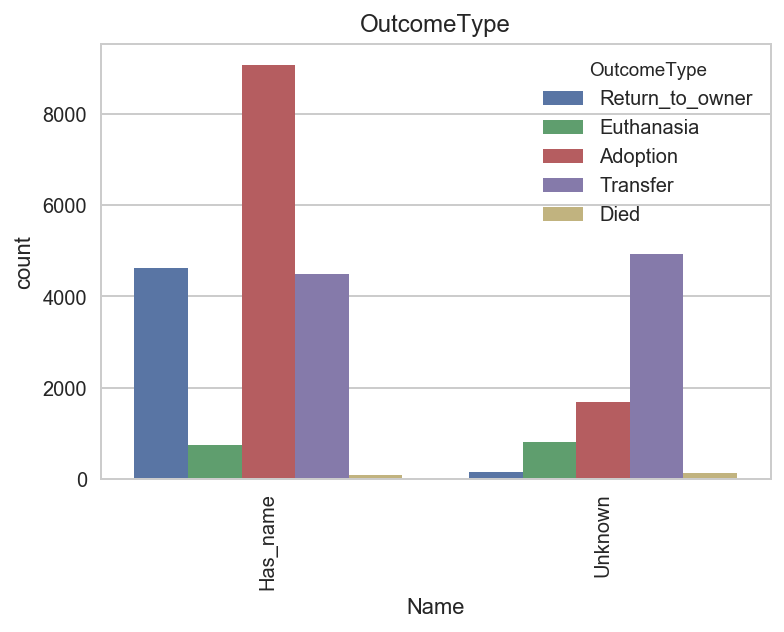

In [158]:
# 이름이 있는 경우 어덥션 높고 이름 없는 경우 transfer 높다.
sns.countplot(x="Name", data=df_train , hue ='OutcomeType')
plt.title('OutcomeType')
plt.xticks(rotation='vertical')
plt.show() 

### - AnimalType & OutcomeType

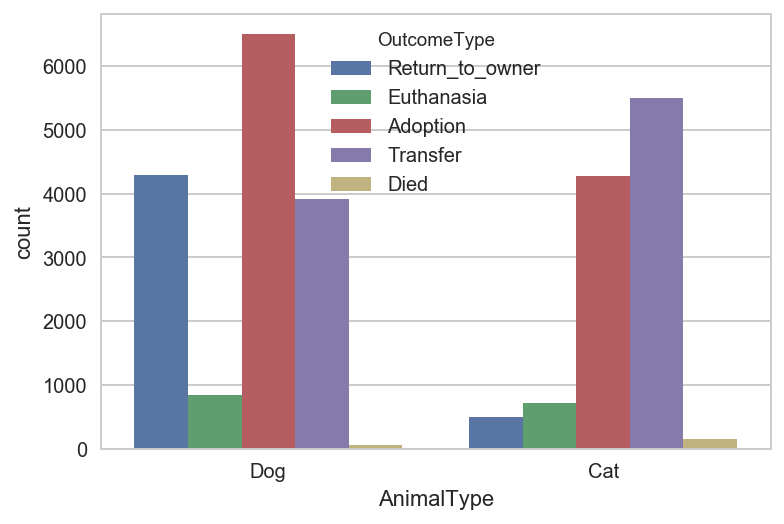

In [159]:
sns.countplot(x='AnimalType',data=df_train, hue='OutcomeType')
plt.show()

### - SexuponOutcome & OutcomeType

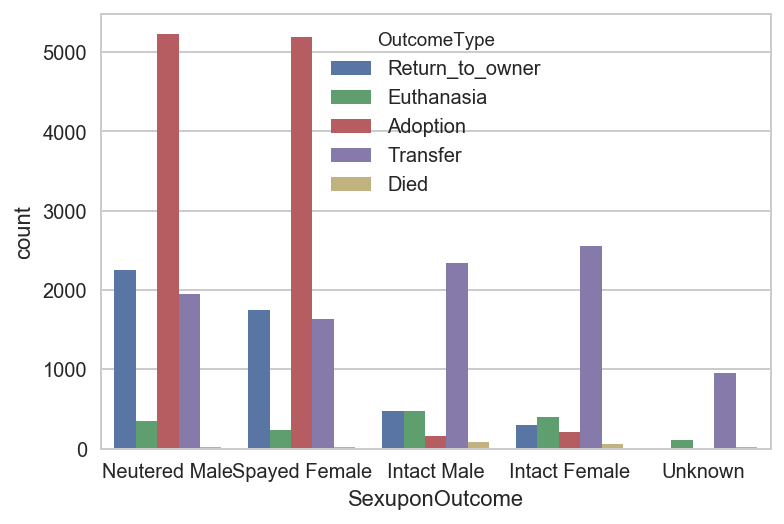

In [160]:
# 중성화 된 동물들의 어덥션이 높고 중성화 되지 않은 동물들이 transfer 된 경우가 많음
sns.countplot(x='SexuponOutcome',data=train, hue='OutcomeType')
plt.show()

### - AgeuponOutcome & OutcomeType

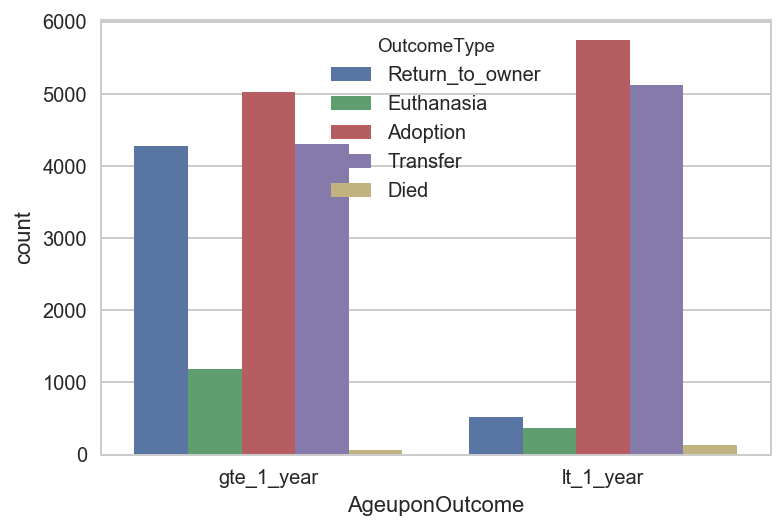

In [163]:
# 1살 이상의 동물들이 주인에게 돌아가는 경우가 많다.
sns.countplot(x='AgeuponOutcome',data=df_train, hue='OutcomeType')
plt.show()

### - Color & OutcomeType

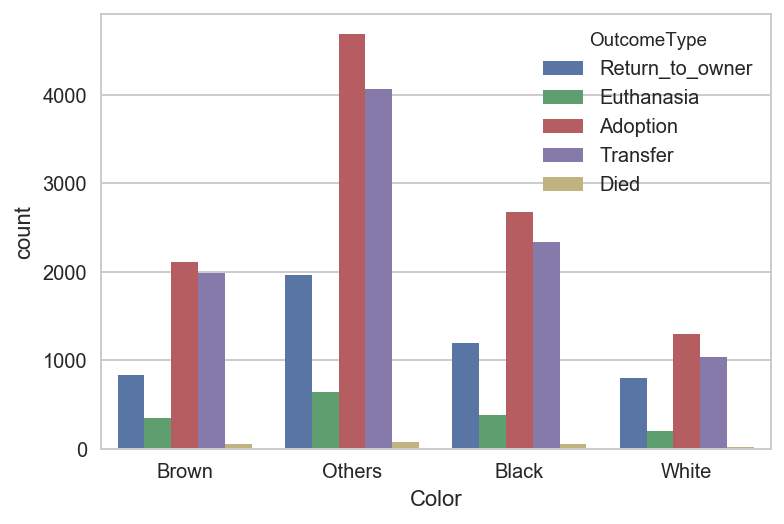

In [67]:
# 색상별로 큰 분포의 차이를 보이진 않아 추후 다른 아이디어를 이용해 볼 예정
sns.countplot(x='Color',data=train, hue='OutcomeType')
plt.show()

### 5-6. Breed

- 개, 고양이의 종류

In [68]:
train['Breed'].tail()

26724     Domestic Shorthair Mix
26725     Domestic Shorthair Mix
26726    Old English Bulldog Mix
26727     Domestic Shorthair Mix
26728     Domestic Shorthair Mix
Name: Breed, dtype: object

In [69]:
len(np.unique(train['Breed']))

1380

### - One-Hot-Encoding

In [205]:
df_X.columns

Index(['Has_name', 'Unknown_name', 'Intact Female', 'Intact Male', 'Neutered Male', 'Spayed Female', 'Unknown_Sex', 'gte_1_year', 'lt_1_year', 'Black', 'Brown', 'C_Others', 'White'], dtype='object')

In [72]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = train['OutcomeType']
le.fit(y)
y= le.transform(y)
y

array([3, 2, 0, ..., 0, 4, 4], dtype=int64)

In [74]:
y

array([3, 2, 0, ..., 0, 4, 4], dtype=int64)

In [195]:
le.classes_

array(['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer'], dtype=object)

## 6. Classification Model
1. 의사결정나무
2. XGBoost
3. 앙상블 = 랜덤포레스트 + XGBoost

In [206]:
df_X.columns = [['Has_name', 'Unknown_name', 'Intact Female', 'Intact Male', 
                 'Neutered Male', 'Spayed Female', 'Unknown_Sex', 'gte_1_year', 'lt_1_year', 
                 'Black', 'Brown', 'C_Others', 'White']]

### 의사결정나무 + cv

Tree Model1: Mean score: 0.524 --- acuraccy score : 0.524
Tree Model2: Mean score: 0.543 --- acuraccy score : 0.543
Tree Model3: Mean score: 0.586 --- acuraccy score : 0.586
Tree Model4: Mean score: 0.612 --- acuraccy score : 0.613
Tree Model5: Mean score: 0.614 --- acuraccy score : 0.614
Tree Model6: Mean score: 0.613 --- acuraccy score : 0.614
Tree Model7: Mean score: 0.613 --- acuraccy score : 0.615
Tree Model8: Mean score: 0.613 --- acuraccy score : 0.615
Tree Model9: Mean score: 0.613 --- acuraccy score : 0.615
Tree Model10: Mean score: 0.613 --- acuraccy score : 0.615
Tree Model11: Mean score: 0.613 --- acuraccy score : 0.615
Tree Model12: Mean score: 0.613 --- acuraccy score : 0.615
Tree Model13: Mean score: 0.613 --- acuraccy score : 0.615
Tree Model14: Mean score: 0.613 --- acuraccy score : 0.615
Tree Model15: Mean score: 0.613 --- acuraccy score : 0.615


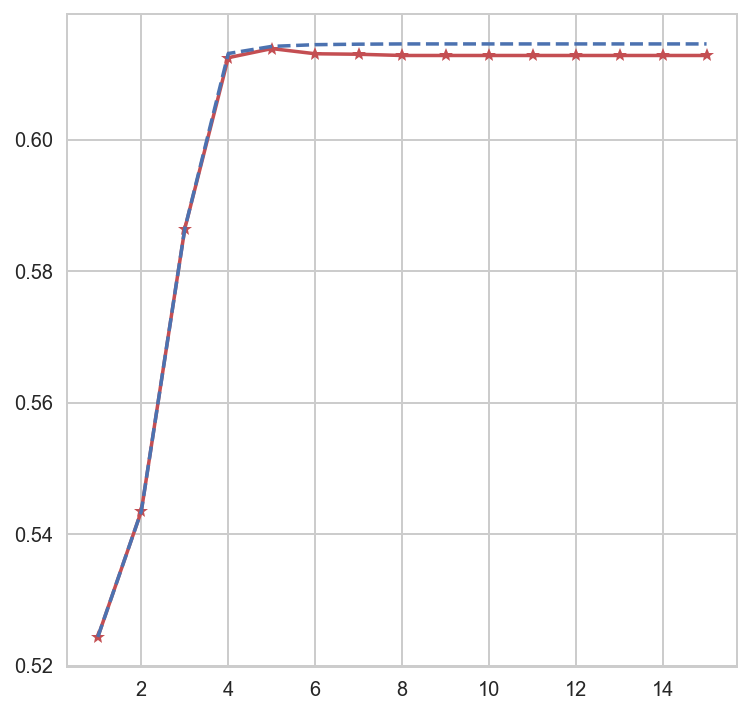

In [219]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score, KFold
tree_ls = []
score_ls = []
accur_ls = []

# tree 모델 자동생성 반복문
for i in range(1,16):
    tree = DecisionTreeClassifier(criterion='entropy', max_depth=i, random_state=0).fit(df_X,y)
    tree_ls.append(tree)

# 모델 CV돌리기
for i, model in enumerate(tree_ls):
    scores = cross_val_score(model, df_X, y,cv=10)
    accuracy = accuracy_score(y,model.predict(df_X))
    print(("Tree Model{0:d}: Mean score: {1:.3f}").format(i+1,np.mean(scores)), end="")
    print((" --- acuraccy score : {0:.3f}").format(accuracy)) # Kfold 안했을때 비교
    score_ls.append(np.mean(scores))
    accur_ls.append(accuracy)
    
# 플롯팅 
plt.figure(figsize=(6,6))
plt.plot(range(1,len(score_ls)+1),list(score_ls),'-*r')
plt.plot(range(1,len(accur_ls)+1),list(accur_ls),'--b')
plt.show()

In [231]:
# plot_decision_regions(df_data,df_target, tree1, "Depth 1")
# plt.show()
treeA = DecisionTreeClassifier(criterion='entropy', max_depth=7, random_state=0).fit(df_X,y)

from sklearn.metrics import *
print("- Accuracy_Score : ", accuracy_score(y,treeA.predict(df_X)))
print("- Confusion_Matrix \n",confusion_matrix(y, treeA.predict(df_X)))
print(classification_report(y, treeA.predict(df_X), target_names=["Adoption","Died","Euthanasia","Return_to_owner","Transfer"]))

- Accuracy_Score :  0.61450110367
- Confusion_Matrix 
 [[10161     0     0    30   578]
 [   31     0     0     2   164]
 [  487     0     5   128   935]
 [ 3954     0     4   381   447]
 [ 3265     0     2   277  5878]]
                 precision    recall  f1-score   support

       Adoption       0.57      0.94      0.71     10769
           Died       0.00      0.00      0.00       197
     Euthanasia       0.45      0.00      0.01      1555
Return_to_owner       0.47      0.08      0.14      4786
       Transfer       0.73      0.62      0.67      9422

    avg / total       0.60      0.61      0.55     26729



C:\Users\creal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### XGBoost + cv 

In [242]:
from sklearn.model_selection import cross_val_score, KFold
model_ls = []
score_ls = []
accur_ls = []

# tree 모델 자동생성 반복문
print("model creating..",end="")
for i in range(1,11):
    grad = xgboost.XGBClassifier(n_estimators=100, max_depth=i, random_state=0).fit(df_X,y)
    print(",",i,end="")
    model_ls.append(grad)

# 모델 CV돌리기
print("\nmodel testing...")
for i, model in enumerate(model_ls):
    scores = cross_val_score(model, df_X, y,cv=10)
    accuracy = accuracy_score(y,model.predict(df_X))
    print(("XGB Model{0:d}: Mean score: {1:.3f}").format(i+1,np.mean(scores)), end="")
    print((" --- acuraccy score : {0:.3f}").format(accuracy)) # Kfold 안했을때 비교
    score_ls.append(np.mean(scores))
    accur_ls.append(accuracy)
    
# 플롯팅 
plt.figure(figsize=(8,8))
plt.plot(range(1,len(score_ls)+1),list(score_ls),'-*r')
plt.plot(range(1,len(accur_ls)+1),list(accur_ls),'--b')
plt.show()

model creating.., 1, 2, 3, 4, 5, 6, 7, 8, 9, 10
model testing...
Tree Model1: Mean score: 0.612 --- acuraccy score : 0.612
Tree Model2: Mean score: 0.612 --- acuraccy score : 0.612
Tree Model3: Mean score: 0.613 --- acuraccy score : 0.613


KeyboardInterrupt: 

### 앙상블에다가 - 랜덤포레스트 + XGBOOST 

In [235]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import xgboost
from sklearn.ensemble import VotingClassifier

model1 = ExtraTreesClassifier(n_estimators=250, criterion="entropy", random_state=0)
model2 = xgboost.XGBClassifier(n_estimators=100, max_depth=5)
ensemble = VotingClassifier(estimators=[('lr', model1),('pda', model2)], voting='soft', weights=[1,2])

In [236]:
model = ensemble.fit(df_X,y)

In [237]:
y_pred = model.predict(df_X)

In [241]:
from sklearn.metrics import *
print(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred, target_names=['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer']))

[[10087     0     0    30   652]
 [   29     0     0     2   166]
 [  471     0     4   129   951]
 [ 3945     0     2   383   456]
 [ 3192     0     0   279  5951]]
                 precision    recall  f1-score   support

       Adoption       0.57      0.94      0.71     10769
           Died       0.00      0.00      0.00       197
     Euthanasia       0.67      0.00      0.01      1555
Return_to_owner       0.47      0.08      0.14      4786
       Transfer       0.73      0.63      0.68      9422

    avg / total       0.61      0.61      0.55     26729



C:\Users\creal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
from sklearn.model_selection import cross_val_score, KFold
np.mean(cross_val_score(model.fit(X,y), X, y, cv=5))

## 7. To improve performace
- AnimalType 별로 나눠서 EDA와 모델 만들어 비교할 예정
- 최적화
- 비대칭 데이터 해결

동물의 처리결과별 - 종 통계


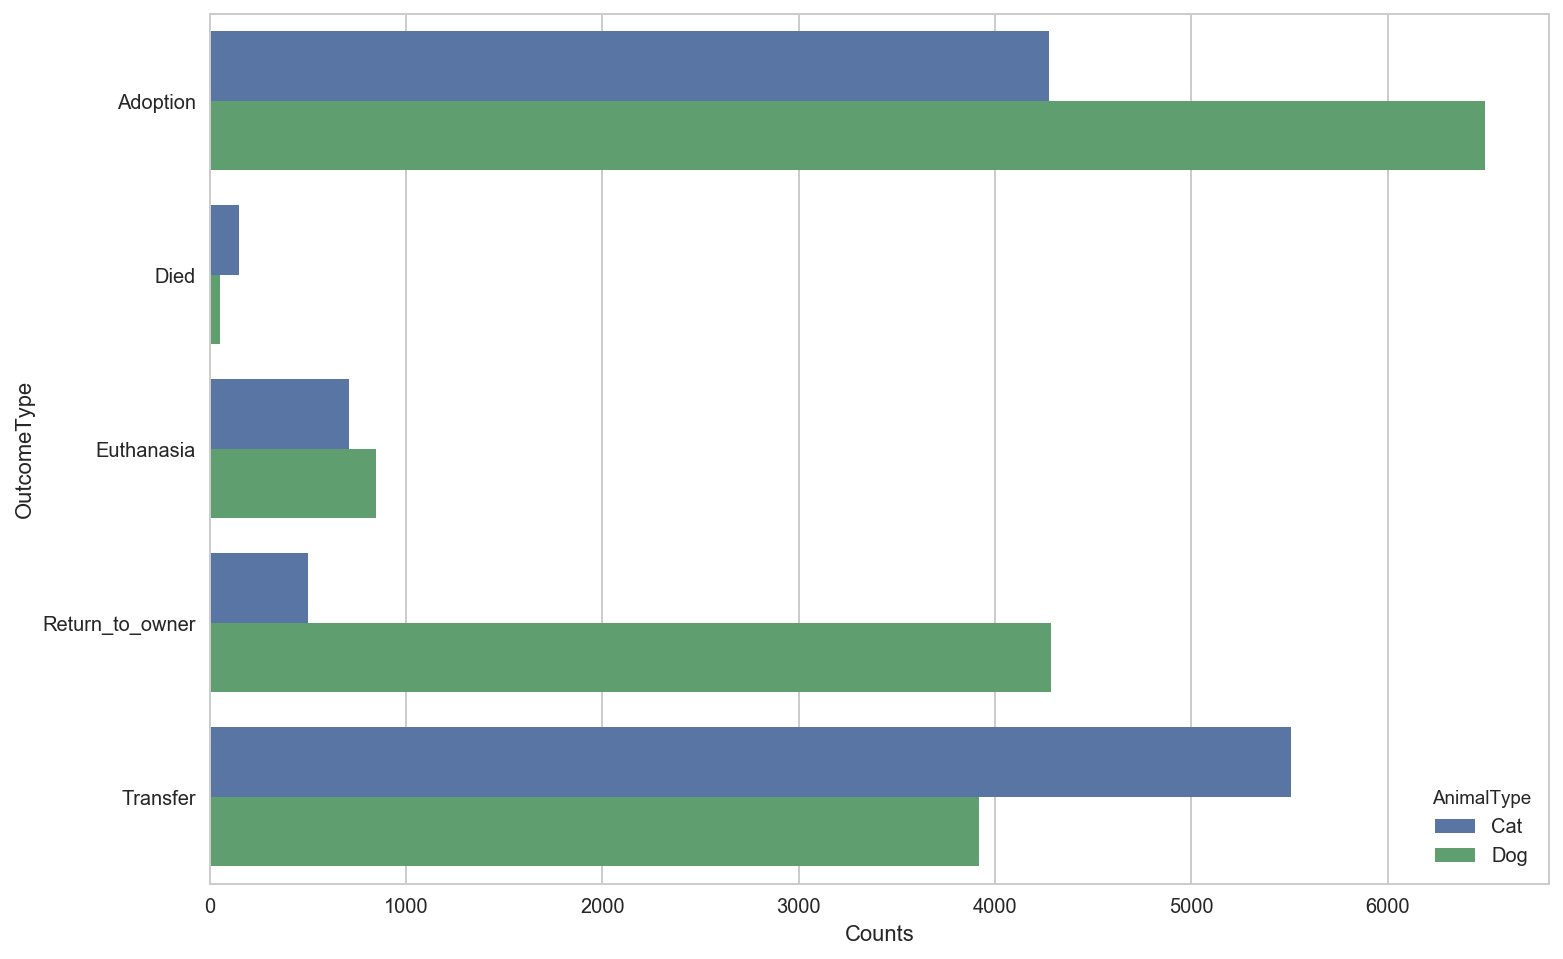

In [84]:
sorted_df = train.groupby(["OutcomeType","AnimalType"]).size().reset_index(name="count")
fig = plt.figure(figsize=(12,8))
ax = sns.barplot(data = sorted_df, x="count", y="OutcomeType", hue="AnimalType")
ax.set_xlabel('Counts')
ax.set_ylabel('OutcomeType')
print("동물의 처리결과별 - 종 통계")
# 0은 1년생 미만의 동물개체
# -1은 나이정보가 없었던 동물